# Run BlueFog with Jupyter Notebook

The **goal** of this ipython notebook is to show you how you can run BlueFog code in ipython notebook environment.

As you know, the BlueFog framework is aimed to run decentralized algorithm over a cluster of processes or machines.
Meanwhile, jupyter notebook is an execellent interactive frontend talking with single IPython process. The contradiction between a single frontend process and a cluster of backend processescan be completely circumvented, fortunately. The main idea is using the jupyter notebook as the driver to inform how the cluster will execute the BlueFog code. On one hand, the execution of BlueFog still runs over multiple processes so that you can enjoy the scalability and parallelism brought by BlueFog. On the other hand, you (the programmer) can interactively execute with BlueFog and monitor and control the code in the single place.

## Prerequisites: 
To begin with, make sure that you have installed OpenMPI and BlueFog in your system first.
Besides these, you also need to install [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/index.html) package for managering the parallel computation.
Usually, you can install it through `pip install jupyter ipyparallel`.

## Steps to start Bluefog with Jupyter Notebook

- **Step 1: Start jupyter notebook**

```shell
jupyter notebook
```

- **Step 2A: Start the `ibfrun` (interactive bluefog run) in a single machine**

```shell
ibfrun start -np 4
```
where `np` means the number of process. In this example command, it will start 4 processes. You are free to choose any number between 1 and the number of CPU processes in you machine. 

- **Step 2B: Start the `ibfrun` in multiple machines**

```shell
ibfrun start -np 16 -H machine-a:4,machine-b:4,machine-c:4,machine-d:4
```
where `machine-a` to `machine-d` are the machine name or the address of the machine and `:4` after the machine name means on that machine launch 4 processes. Before you run this command, please make sure that all the machines is able to be login through `ssh` **without** typing the password.

That's it!

**Other remarks**
- Please make sure the jupyter notebook command and the ibfrun command are under the same machine.
- If you want to communicate over GPUs through NCCL, the number of process in each machine should not exceed the number GPUs instead of CPUs.



In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# Connect the Jupyter Notebook to the workers

The first step is to let the jupyter notebook connect to the workers (cluster). To achieve that, import the ipypyarallel library since we rely on it to manage the workers, then connect it through `ipp.Client(profile="bluefog")` as shown in the following cell.

`rc` (remote client) class is the key that you will use to send the code from this notebook (driver) to the workers. Remote client is called as such because it talks with the workers, which may not be on the local host.
To check if the notebook has connected to the worker succesfully, you can look the ID of rc through `rc.ids`.
Depending on how many processes you start, the length of rc will be the same number as the number of processes you start the `ibfrun`, i.e., the number after `-np`.

In [2]:
import ipyparallel as ipp
rc = ipp.Client(profile="bluefog")
rc.ids

[0, 1, 2, 3]

If you saw the `ids` is an empty list, this means ipyparallel cannot connect it with the workers. You can stop the `ibfrun` by `ctrl+c`. Kill all remainning `ipcontroller` or `mpi` processes through `ps` if necessary. Then, try to rerun the `ibfrun` again.

#  Parallel execution through `px`

`px` -- parallel execution is a [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) in IPython environment similar as `%matplotlib` or `%%timeit`. If you are not familar with magic command, you can think it as a special command in IPython that will change the behavior of IPython interpreting the following python code. 

Same as other magic commands, `%px` is for one line and `%%px` is for whole cell. For example, 
`%px print("Hello world")` will put `print("Hello world")` to run under the `px` environment. And, if you put the `%%px` at the top of one cell, the rest of code in that cell will be run under the `px` environment.

The code under the `px` env will be executed in each worker in parallel instead of running in this notebook.
It is important to remember that each worker is one seperated IPython environment. The following is a hello-world example to work with bluefog in jupyter notebook, which is already sufficient for most  usage cases. You can find more advanced usage of `px` in the [document page](https://ipyparallel.readthedocs.io/en/latest/magics.html).


All BlueFog code should start with `bf.init()`:

In [3]:
%%px
import bluefog.torch as bf

bf.init()
message = f"Hello, I am {bf.rank()} among {bf.size()} processes"
print(message)

[stdout:0] Hello, I am 0 among 4 processes
[stdout:1] Hello, I am 1 among 4 processes
[stdout:2] Hello, I am 3 among 4 processes
[stdout:3] Hello, I am 2 among 4 processes


You should see `Hello, I am {x} among {np} processes` repeated `np` time where `x` ranges from 0 to np-1. This `x` is called rank. Note the code is the same while the outputs from the cluster of processes are different. This is the typical usage of BlueFog code, which belongs to the Single Instruction, Mutliple Data [SIMD](https://en.wikipedia.org/wiki/SIMD) pattern.

You can also use `%px` for one line. A typical usage of `%px` is mixing the control flow code of notebook and the execution code in the workers:

In [4]:
print("=" * 42)
for _ in range(2):
    %px print(message)
    print("=" * 42)

[stdout:0] Hello, I am 0 among 4 processes
[stdout:1] Hello, I am 1 among 4 processes
[stdout:2] Hello, I am 3 among 4 processes
[stdout:3] Hello, I am 2 among 4 processes
[stdout:0] Hello, I am 0 among 4 processes
[stdout:1] Hello, I am 1 among 4 processes
[stdout:2] Hello, I am 3 among 4 processes
[stdout:3] Hello, I am 2 among 4 processes


Because each worker is a IPython environment, it will remember the context of execution. Hence, the `message` variable is still the same `message` variable created in previous cell and `bf.init()` just needs to be called once.

# Moving the data between notebook and workers

Only executing the BlueFog code in multiple workers through notebook is not interesting enough. Because all running results only remain in the workers. The notebook does not know those results by default. You can try to run `print(message)` in the cell without `px`, you will encounter the `NameError`, i.e., that variable is not defined under the notebook.

Fortunately, we can easily extract or pass the data or objects between notebook and workers.
The key componenet is [Direct View class](https://ipyparallel.readthedocs.io/en/latest/direct.html#) through `dview=rc[:]`. Using `dview.push()` and `dview.pull()`, they transmit the data between workers and notebook.

In [5]:
%%px
import torch
x = torch.FloatTensor([bf.rank()])

Now each worker creates a tensor `x` containing the 1x1 value equal to its corresponding rank.

In [6]:
dview = rc[:] # A DirectView of all engines
dview.block=True
x_at_worker0 = dview.pull('x', targets=0)
x_at_worker0

tensor([0.])

What the code above did is that notebook pulls the value `x` of worker 0 and stores that as `x_at_worker0` in the notebook. Note the worker 0 may not be the worker that has rank 0. Hence, the value of `x_at_worker0` may not be zero. You also pull the results from all workers or part of them.

In [7]:
xs_at_1_and_2 = dview.pull('x', targets=[1, 2])
xs_at_1_and_2

[tensor([1.]), tensor([3.])]

In [8]:
xs_all = dview.pull('x')
xs_all

[tensor([0.]), tensor([1.]), tensor([3.]), tensor([2.])]

You can also push the data from the notebook to all workers through `dview.push(arg)`, where the `arg` is a dictionary that map from the variable name to variable value.

In [9]:
# Push the data into all workers
dview.push({'seed': 12345})

[None, None, None, None]

In [10]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  12345
[stdout:1] I received seed as value:  12345
[stdout:2] I received seed as value:  12345
[stdout:3] I received seed as value:  12345


## (Optional) Working with multiple GPUs

If you have multiple GPUs, it is typical that each worker is pinned to one device.
Then, you can let the tensor wihin each worker set on different GPUs as shown in following code.

*Note: If you want to pin multiple workers in one device, you cannot use NCCL as communication backend.*

In [11]:
%%px
import torch
if torch.cuda.is_available():
    torch.cuda.set_device(bf.local_rank())
    x = torch.FloatTensor([bf.rank()]).cuda()
    print(x)

[stdout:0] tensor([0.], device='cuda:0')
[stdout:1] tensor([1.], device='cuda:1')
[stdout:2] tensor([3.], device='cuda:3')
[stdout:3] tensor([2.], device='cuda:2')


# A simple average-consensus example

Now, with the `px` magic command and the direct-view class, we are good to run a simple average-consensus example.

In [11]:
%%px

# It is important to give different random seeds to different workers.
torch.random.manual_seed(seed * bf.rank() + bf.rank())

data_size = 10
max_iters = 100

In [12]:
%%px
import bluefog.common.topology_util as topology_util

# Set exponential-2 graph as topology, which is default actaully.
assert bf.set_topology(topology_util.ExponentialTwoGraph(bf.size()))

# Create a random data to run consensus
x = torch.randn(data_size, dtype=torch.double)

# Use allreduce to find the truth of average for reference
x_bar = bf.allreduce(x, average=True)

mse = []
for ite in range(max_iters):
    # The following code is equivalent to:
    #  x_i = \sum_{j\in Neighbor(i)} a_ij x_j
    # where a_ij is entry of the combination matrix 
    # that definied through the set_topology command.
    x = bf.neighbor_allreduce(x, name='x')
    mse.append(torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2))

In [13]:
mse_0 = dview.pull('mse', block=True, targets=0)

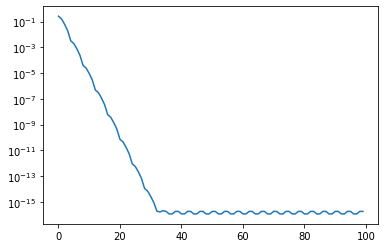

In [14]:
plt.semilogy(mse_0)

You can also plot the multiple figures from multiple works by adding `--targets 1:3` after `px`. In this case, worker 1 and worker 2 will plot the figures.

[output:1]

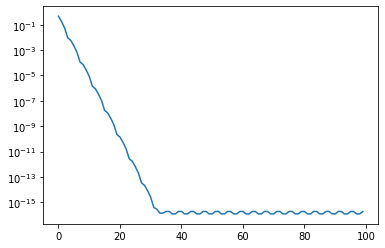

[output:2]

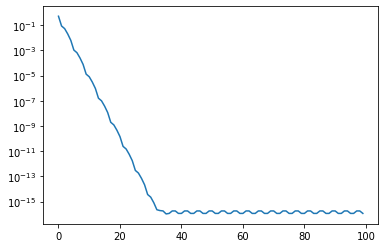

In [15]:
%%px  --targets 1:3
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogy(mse)
plt.show()

# Interrupt the hanged worker process

It is quite common in the code dealing with the multiple machine communication that some unexpected bugs or deadlock cause the worker process(es) hang forever. Recall the worker processes are inside a seperated environment from the notebook. Hence, the 'interrupt the kernel' button, i.e. black square box, in the toolbar of the notebook interrupts the code of execution in notebook but the worker processes are still running.

Let's use `sleep()` function to simulate that situation. If you run the following code and click the interrupt button afterwards, you will be able to execute other cells but the workers still continue to sleep, which will block the running of other requests.

In [ ]:
%%px
import time
time.sleep(1000)

In [ ]:
%%px

# You will not see the output immediately, even if you stop the previous cell.
# It is because the workers are still sleeping. The interruption in notebook
# does not interrupt the workers.
print("Done")

Therefore, BlueFog provides a utility function `interrupt_hanged_processes()`. After running this function, the previous `sleep()` function will be interrupted so that you should be able to execute other functions afterwards. Meanwhile, the context of IPython remains.

*Note: `interrupt_hanged_processes()` is supported under the localhost mode only.*

In [ ]:
from bluefog.run.interactive_run import interrupt_hanged_processes
interrupt_hanged_processes(profile="bluefog")

In [ ]:
%%px

# Now you should see the output immediately.
print("Done")

# What happens after you run `ibfrun`

If you are curious about what happened after running the `ibfrun` command, the following figure should give you a good overview.

<img src="./images/ibfrun.png" alt="ibfrun" width="780"/>

When you start the jupyter notebook, you will create a IPython client, which will keep recieving and executing the command from the notebook. `ibfrun` will create a controller and a bunch of workers (They are actually IPython Kernels) under the MPI environment. The controller knows how to communicate with the IPython client and the workers. When you execute the code under `px` environment, the following procedure happens:

1. The notebook sends the user code back to the IPython client.
2. The IPython client notices this code is needed to be run under `px` so it forwards the code to the controller.
3. The controller forwards the code to the worker according to `--targets`. By default, it forwards to all workers.
4. The workers accept the command and execute it in parallel. If there is data exchange among the processes, the communication will be performed through the MPI or NCCL.
5. After all workers finish executing the code, the jupyter notebook will be notified that the execution is done.


As for the `push` and `pull` commands in direct view, their execution procedures are similar as the `px` data flow.

Last, notice that `ibfrun` is just a thin wrapper for convenience over the command provided by the `ipyparallel`. If you have some speical requirement or you have problem of executing `ibfrun`, you can use the `ipcontroller` or `ipengin` command directly. Check [ipyparallel document](https://ipyparallel.readthedocs.io/en/latest/process.html) for more details.

## Suspend BlueFog
Bluefog launches a background process, which may consume CPUs a lot.
even if you don't use it actively. You can suspend it through `bf.suspend()`.
Note after it is suspended, you are no longer able to run BlueFog communication functions.
You can continue the usage through `bf.resume()` again.

In [ ]:
%%px
bf.suspend()

In [ ]:
%%px
bf.resume()